## Importing Needed Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Reading The Dataset

In [3]:
data_dir = "/content/goldstock (7).csv"
df = pd.read_csv(data_dir, parse_dates=True, index_col='Date')

## Exploring The Dataset

In [4]:
df.head()

,Unnamed: 0,Close,Volume,Open,High,Low
Date,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2024-01-19 to 2014-01-22
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Close       2511 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2511 non-null   float64
 4   High        2511 non-null   float64
 5   Low         2511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 137.3 KB


In [6]:
df.describe()

,Unnamed: 0,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1260.792911,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,729.262879,298.824811,97600.769382,299.118187,301.262244,296.417703
min,0.000000,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,630.500000,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1259.000000,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1888.500000,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2532.000000,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


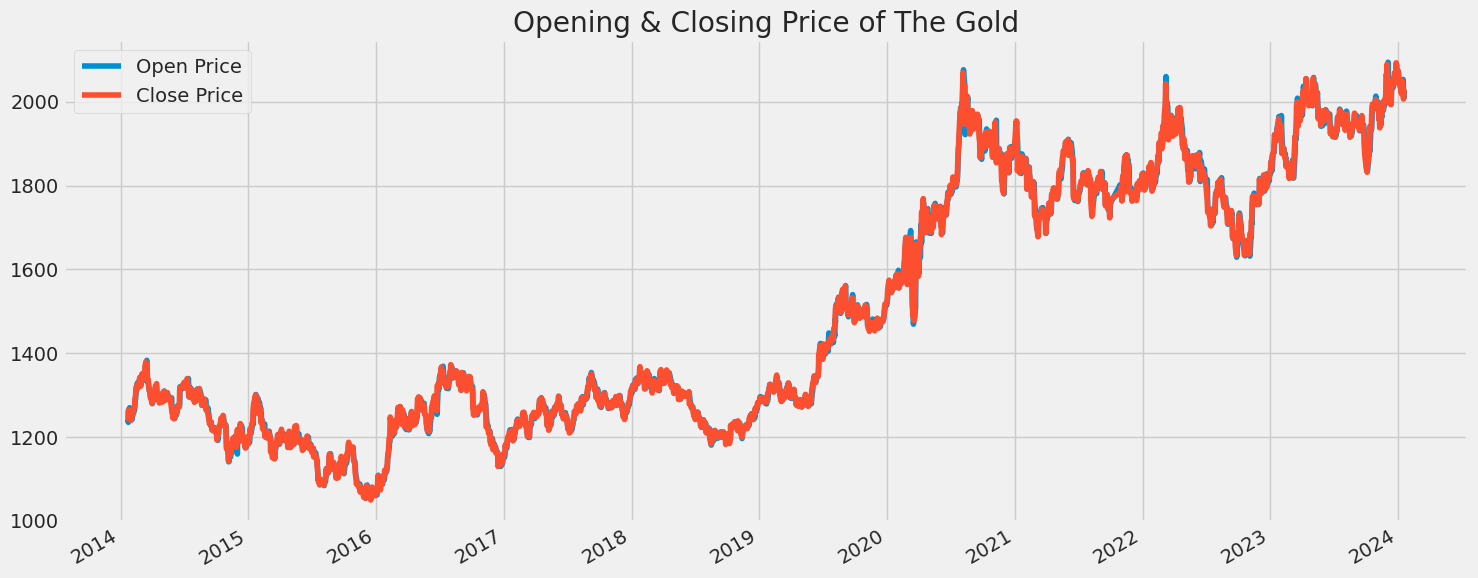

In [7]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of The Gold")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

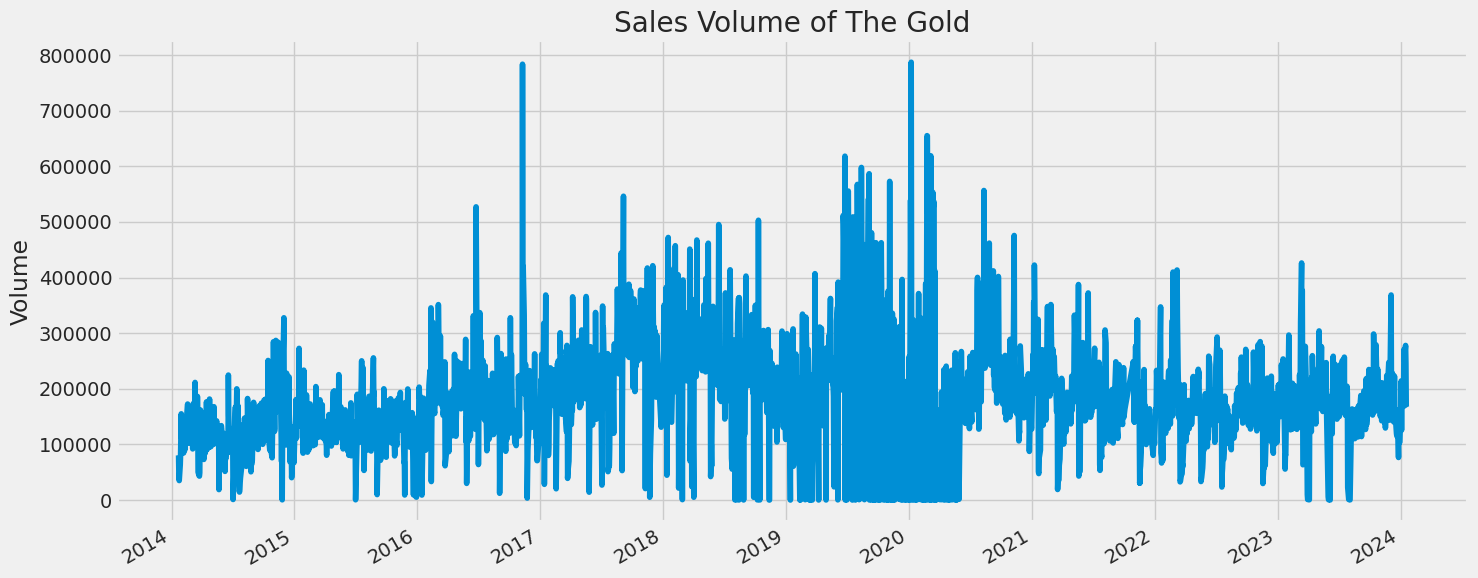

In [8]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of The Gold")
plt.tight_layout()
plt.show()

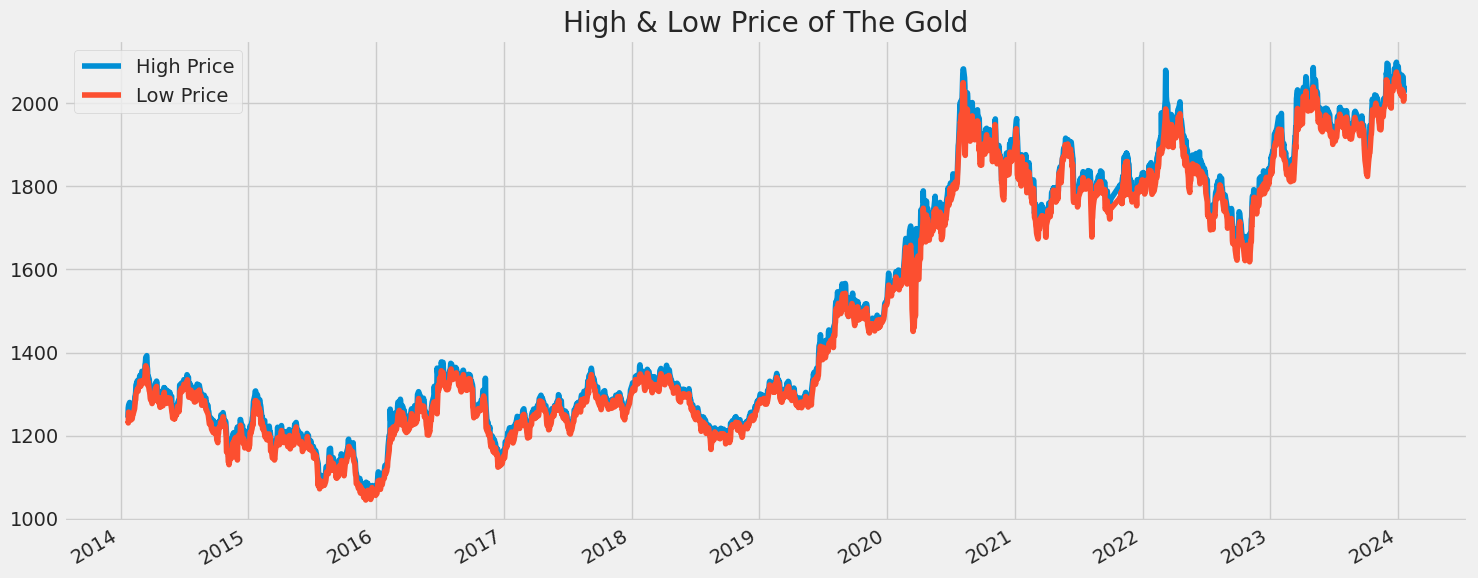

In [9]:
plt.figure(figsize=(15, 6))
df['High'].plot()
df['Low'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("High & Low Price of The Gold")
plt.legend(['High Price', 'Low Price'])
plt.tight_layout()
plt.show()

## Preprocessing The Data

**Choose The Prediction Column**

In [11]:
dataset = df['Close']
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(2511, 1)

**Normalizing The Data**

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

**Splitting The Data**

In [14]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size

print("Train Size: ", train_size)
print("Test Size: ", test_size)

train_data = scaled_data[:train_size, 0:1]
test_data = scaled_data[train_size-60:, 0:1]

Train Size:  2008
Test Size:  503


In [15]:
print(train_data.shape)
print(test_data.shape)

(2008, 1)
(563, 1)


**Creating The Training Set**

In [17]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
print(x_train.shape)
print(y_train.shape)

(1948, 60, 1)
(1948,)


## LSTM Model

**Model Structure**

In [29]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics= ["mean_absolute_error"])

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [28]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0434 - mean_absolute_error: 0.1345
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0012 - mean_absolute_error: 0.0265
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0011 - mean_absolute_error: 0.0251
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0012 - mean_absolute_error: 0.0265
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0012 - mean_absolute_error: 0.0261
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 9.6975e-04 - mean_absolute_error: 0.0234
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.2787e-04 - mean_absolute_error: 0.0230
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 9.2163e-04 - mean_absolute_error: 0.0226
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0010 - mean_absolute_error: 0.0235
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 9.1462e-04 - mean_absolute_error: 0.0227
Epoch 11/100


**Model Evaluation**

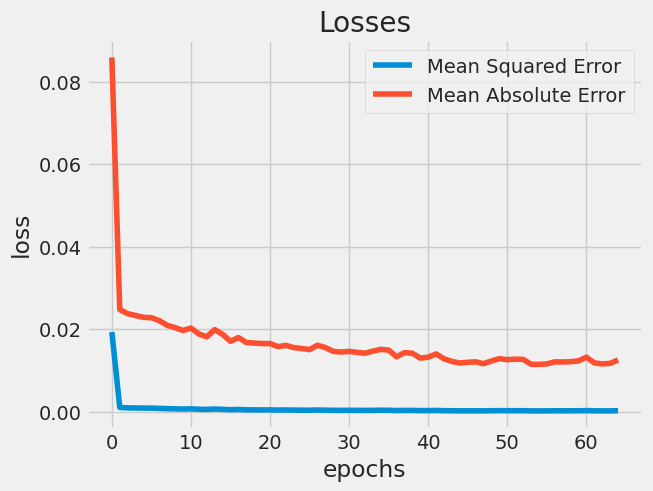

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Prediction

**Creating Testing Set**

In [32]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
x_test.shape , y_test.shape

((503, 60, 1), (503,))

In [34]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


(503, 1)

**Root Mean Square Error**

In [35]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(133.7)

**Visualizing Predictions with The Data**

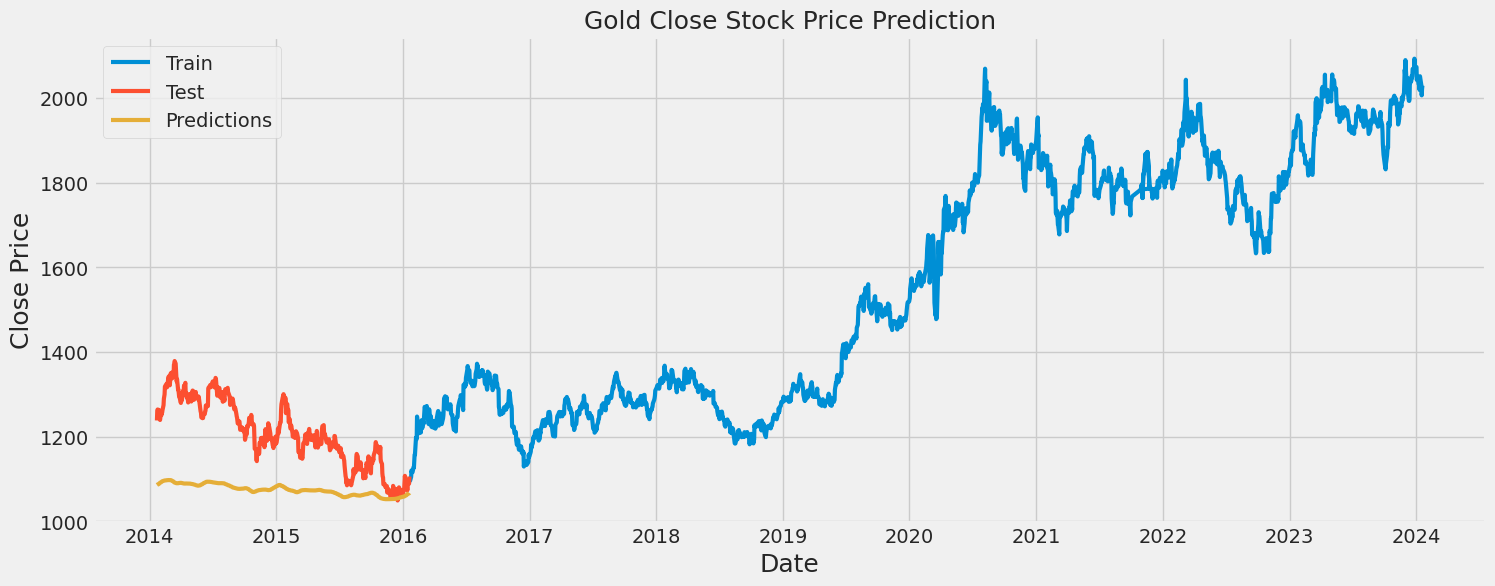

In [36]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Gold Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])
plt.show()

## Forecast Next 30 Days

In [37]:
from datetime import timedelta

In [40]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]

    Xin[:, timestep - 1, :] = new_input
    return Xin

In [39]:
future = 30
forcast = []
Xin = x_test[-1:, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[np.float32(0.035150032)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[np.float32(0.035150032), np.float32(0.034913555)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[np.float32(0.035150032), np.float32(0.034913555), np.float32(0.03427087)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[np.float32(0.035150032), np.float32(0.034913555), np.float32(0.03427087), np.float32(0.03307483)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[np.float32(0.035150032), np.float32(0.034913555), np.float32(0.03427087), np.float32(0.03307483), np.float32(0.031386208)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[np.float32(0.035150032), np.float32(0.034913555), np.float32(0.03427087), np.float32(0.03307483), np.float32(0.031386208), np.float32(0.029344155)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[np.float32(0.035150032), np.float32(0.034913555), np.float32(0.03427087), np.float32(0.03307483), np.float32(0.031386208), np.float32(0.029344155), np.float32(0.027098635)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste

In [41]:
time

[Timestamp('2014-01-22 00:00:00'),
 Timestamp('2014-01-23 00:00:00'),
 Timestamp('2014-01-24 00:00:00'),
 Timestamp('2014-01-25 00:00:00'),
 Timestamp('2014-01-26 00:00:00'),
 Timestamp('2014-01-27 00:00:00'),
 Timestamp('2014-01-28 00:00:00'),
 Timestamp('2014-01-29 00:00:00'),
 Timestamp('2014-01-30 00:00:00'),
 Timestamp('2014-01-31 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-02-02 00:00:00'),
 Timestamp('2014-02-03 00:00:00'),
 Timestamp('2014-02-04 00:00:00'),
 Timestamp('2014-02-05 00:00:00'),
 Timestamp('2014-02-06 00:00:00'),
 Timestamp('2014-02-07 00:00:00'),
 Timestamp('2014-02-08 00:00:00'),
 Timestamp('2014-02-09 00:00:00'),
 Timestamp('2014-02-10 00:00:00'),
 Timestamp('2014-02-11 00:00:00'),
 Timestamp('2014-02-12 00:00:00'),
 Timestamp('2014-02-13 00:00:00'),
 Timestamp('2014-02-14 00:00:00'),
 Timestamp('2014-02-15 00:00:00'),
 Timestamp('2014-02-16 00:00:00'),
 Timestamp('2014-02-17 00:00:00'),
 Timestamp('2014-02-18 00:00:00'),
 Timestamp('2014-02-

**Creating Forecasted DataFrame**

In [42]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [43]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

**Forecasted Gold Close Price**

In [44]:
df_result

,Date,Forecasted
0,2014-01-22,1086.279053
1,2014-01-23,1086.032349
2,2014-01-24,1085.361572
3,2014-01-25,1084.113525
4,2014-01-26,1082.351562
5,2014-01-27,1080.220581
6,2014-01-28,1077.877441
7,2014-01-29,1075.457764
8,2014-01-30,1073.065430
9,2014-01-31,1070.772461


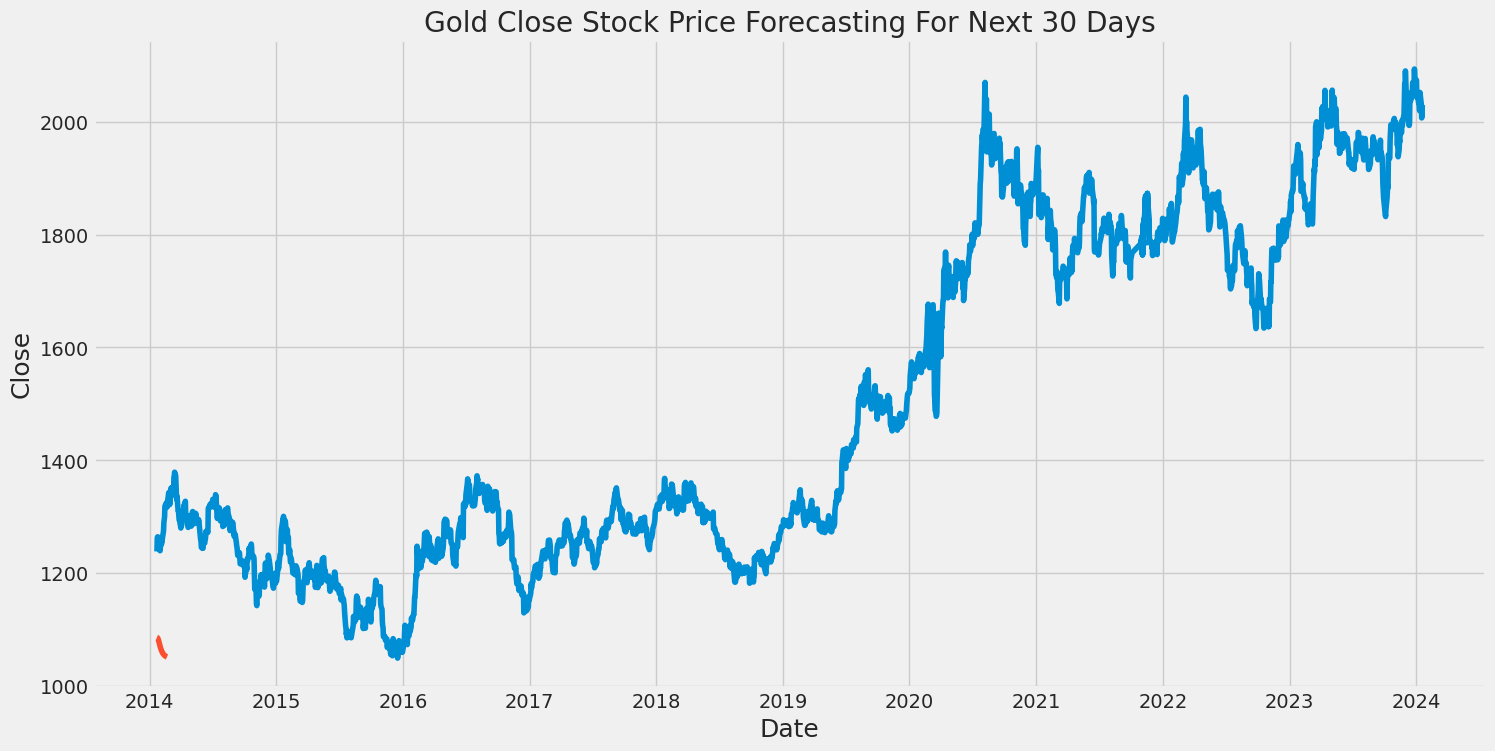

In [45]:
plt.figure(figsize=(16, 8))
plt.title('Gold Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])